In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Checks for available GPUs and lists them
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use only the first GPU
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPU, 1 Logical GPU


In [6]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

In [7]:
# Load structured data
train_data = pd.read_csv('../datasets/petfinder-adoption-prediction/train/train.csv')
test_data = pd.read_csv('../datasets/petfinder-adoption-prediction/test/test.csv')

# Drop non-numeric and non-relevant columns
columns_to_drop = ['Name', 'RescuerID', 'Description', 'PetID']
train_data_numeric = train_data.drop(columns=columns_to_drop)
test_data_numeric = test_data.drop(columns=columns_to_drop)

# Convert categorical columns to dummy variables
train_data_preprocessed = pd.get_dummies(train_data_numeric, drop_first=True)
test_data_preprocessed = pd.get_dummies(test_data_numeric, drop_first=True)

# Extract features and target variable for training and testing
y_train = train_data_preprocessed['Type'].values - 1  # Types to 0 and 1
y_test = test_data_preprocessed['Type'].values - 1  # Types to 0 and 1
X_train_structured = train_data_preprocessed.drop(columns=['Type', 'AdoptionSpeed'])
X_test_structured = test_data_preprocessed.drop(columns=['Type'])

# Scale the features
scaler = StandardScaler()
X_train_structured_scaled = scaler.fit_transform(X_train_structured)
X_test_structured_scaled = scaler.transform(X_test_structured)

# Apply SVD
svd = TruncatedSVD(n_components=10)
X_train_svd = svd.fit_transform(X_train_structured_scaled)
X_test_svd = svd.transform(X_test_structured_scaled)


In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, pet_ids, structured_data, labels, image_dir, batch_size=32, image_size=(224, 224), shuffle=True):
        'Initialization'
        self.pet_ids = pet_ids
        self.structured_data = structured_data
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.pet_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pet_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        pet_ids_temp = [self.pet_ids[k] for k in indexes]

        # Generate data
        X_image = self.__load_images(pet_ids_temp)
        X_structured = self.structured_data[indexes]
        y = self.labels[indexes]

        return [X_image, X_structured], y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_images(self, pet_ids_temp):
        'Loads and preprocesses images'
        images = np.empty((self.batch_size, *self.image_size, 3))
        for i, pet_id in enumerate(pet_ids_temp):
            image_path = os.path.join(self.image_dir, f'{pet_id}-1.jpg')
            if os.path.exists(image_path):
                image = load_img(image_path, target_size=self.image_size)
                image = img_to_array(image)
                images[i,] = preprocess_input(image)
            else:
                # If the image file does not exist, use a zero array as a placeholder
                images[i,] = np.zeros((*self.image_size, 3))
        return images


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16

def build_cnn_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs=base_model.input, outputs=x)
    for layer in base_model.layers:
        layer.trainable = False
    return cnn_model

cnn_model = build_cnn_model((224, 224, 3))


In [6]:
from tensorflow.keras.layers import Concatenate

# Assuming the SVD output size is 10
structured_input = Input(shape=(10,))
cnn_input = Input(shape=(224, 224, 3))

# Get features from both models
structured_features = Dense(256, activation='relu')(structured_input)
cnn_features = cnn_model(cnn_input)

# Combine features from CNN and SVD
combined_features = Concatenate()([cnn_features, structured_features])
combined_features = Dense(512, activation='relu')(combined_features)
predictions = Dense(2, activation='softmax')(combined_features)

# Complete model
model = Model(inputs=[cnn_input, structured_input], outputs=predictions)


In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Initialize data generators
train_generator = DataGenerator(
    pet_ids=train_data['PetID'],
    structured_data=X_train_svd,
    labels=y_train,
    image_dir='../datasets/petfinder-adoption-prediction/train_images/',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)

# Assuming you've split your test data into validation set
validation_generator = DataGenerator(
    pet_ids=test_data['PetID'],
    structured_data=X_test_svd,
    labels=y_test,
    image_dir='../datasets/petfinder-adoption-prediction/test_images//',
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)


Epoch 1/5


2024-04-04 22:32:22.519326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


937/937 [==============================] - 182s 194ms/step - loss: 0.5006 - accuracy: 0.9415 - val_loss: 0.2608 - val_accuracy: 0.9602
Epoch 2/5
937/937 [==============================] - 227s 242ms/step - loss: 0.3396 - accuracy: 0.9519 - val_loss: 0.3381 - val_accuracy: 0.9559
Epoch 3/5
937/937 [==============================] - 256s 273ms/step - loss: 0.8309 - accuracy: 0.9433 - val_loss: 0.7670 - val_accuracy: 0.9541
Epoch 4/5
937/937 [==============================] - 264s 281ms/step - loss: 2.1048 - accuracy: 0.9439 - val_loss: 3.5246 - val_accuracy: 0.9332
Epoch 5/5
937/937 [==============================] - 274s 292ms/step - loss: 3.1041 - accuracy: 0.9488 - val_loss: 1.8304 - val_accuracy: 0.9635


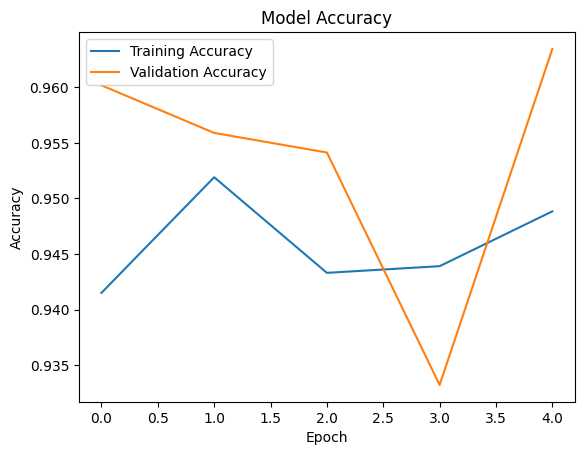

In [8]:
# Plot accuracy per epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

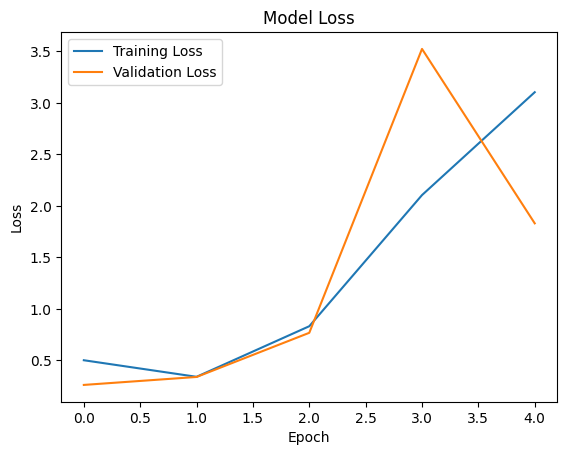

In [9]:
# Plot accuracy per epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()